In [29]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch

from combo_dl.graph_tools import edge_vector_to_adjacency_matrix
from combo_dl.problems import StronglyRegularGraphs

device = torch.device("mps")

In [30]:
checkpoint_dir = Path("../checkpoints/dce_20251006_2225")
checkpoint_files = list(checkpoint_dir.glob("checkpoint_*.pt"))
iterations = [int(file.stem.split("_")[1]) for file in checkpoint_files]
latest_iteration = max(iterations)
best_construction_path = checkpoint_dir / f"best_iter{latest_iteration}.pt"
print(f"Loading checkpoint: {best_construction_path}")

sys.path.insert(0, str(Path.cwd().parent / "src"))

Loading checkpoint: ../checkpoints/dce_20251006_2225/best_iter245.pt


In [31]:
checkpoint = torch.load(best_construction_path, map_location="cpu")
edge_vector = checkpoint["best_construction"]

n = checkpoint["config"]["n"]
k = checkpoint["config"]["k"]
lambda_param = checkpoint["config"]["lambda"]
mu = checkpoint["config"]["mu"]

problem = StronglyRegularGraphs(n, k, lambda_param, mu)

reward = checkpoint["best_score"]

if edge_vector.dim() == 1:
    edge_vector = edge_vector.unsqueeze(0)

best_adj = edge_vector_to_adjacency_matrix(edge_vector, n).squeeze(0)

print(f"Graph size: {n} x {n}")
print(f"Stored reward: {checkpoint['best_score']:.6f} (Goal: 0.0)")
print(f"Iteration: {checkpoint['iteration']}")
print(f"Problem parameters: n={n}, k={k}, lambda={lambda_param}, mu={mu}")
print("\nAdjacency matrix:")
print(best_adj.numpy().astype(int))

Graph size: 10 x 10
Stored reward: -0.000000 (Goal: 0.0)
Iteration: 245
Problem parameters: n=10, k=3, lambda=0, mu=1

Adjacency matrix:
[[0 1 1 0 0 0 0 1 0 0]
 [1 0 0 1 0 0 1 0 0 0]
 [1 0 0 0 1 1 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 1]
 [0 0 1 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 1 0 0 1]
 [0 1 0 0 0 1 0 0 1 0]
 [1 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 1 0 1 1 0 0]
 [0 0 0 1 0 1 0 1 0 0]]


In [32]:
degrees = best_adj.sum(dim=1)
print(f"Degree range: {degrees.min()}-{degrees.max()}, target: {k}")
print(f"Vertices with wrong degree: {(degrees != k).sum()}/{n}")
print()

eigenvalues = torch.linalg.eigvalsh(best_adj.float())
rounded_eigs = eigenvalues.round(decimals=1)
unique_eigs, counts = torch.unique(rounded_eigs, return_counts=True)
eig_table = pd.DataFrame({
    "Eigenvalue": [f"{eig:.1f}" for eig in unique_eigs],
    "Multiplicity": list(counts),
})

print(eig_table.to_string(index=False))

Degree range: 3.0-3.0, target: 3
Vertices with wrong degree: 0/10

Eigenvalue Multiplicity
      -2.0    tensor(4)
       1.0    tensor(5)
       3.0    tensor(1)


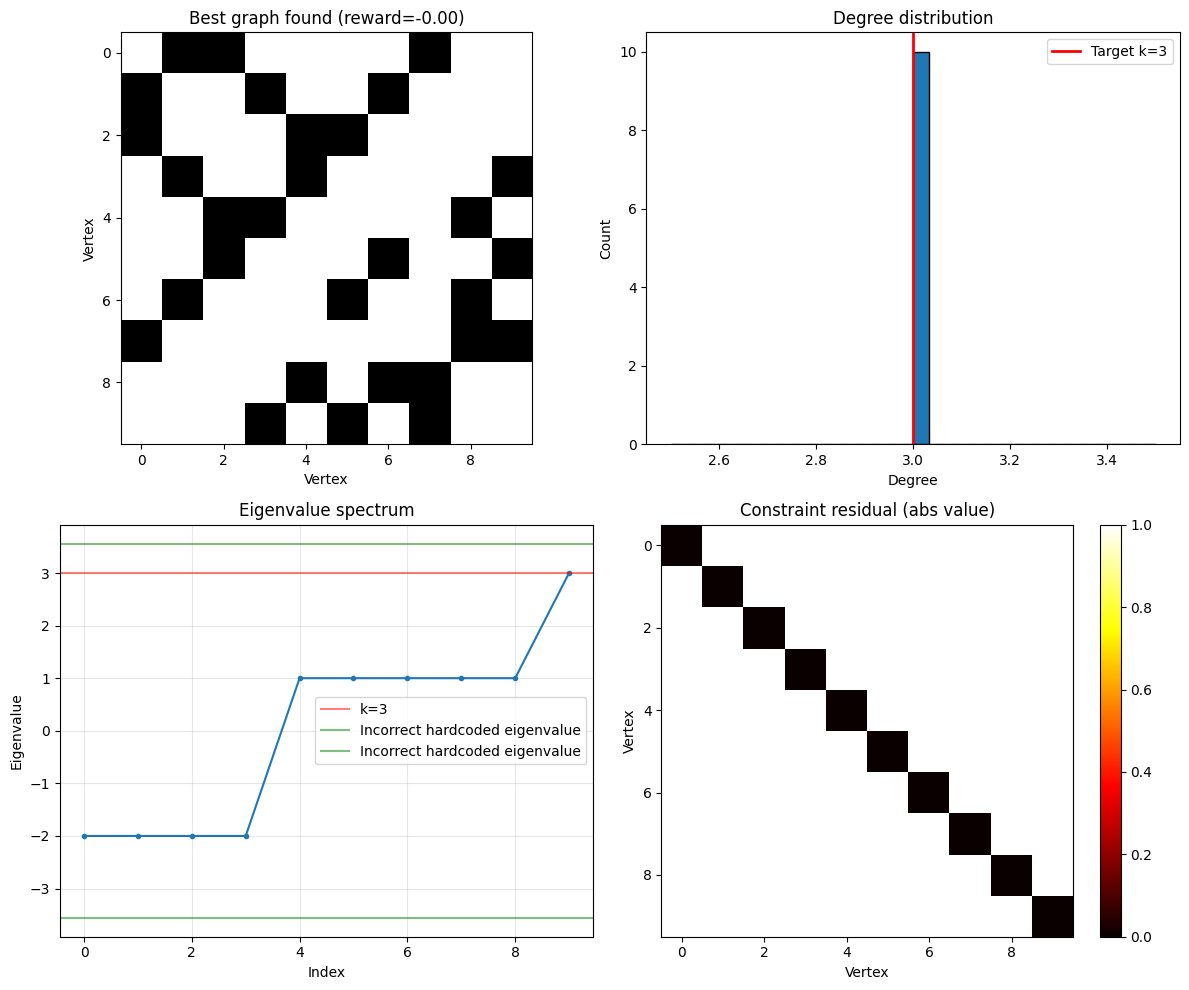


Residual norm: 9.49


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(best_adj.numpy(), cmap="binary")
axes[0, 0].set_title(f"Best graph found (reward={reward:.2f})")
axes[0, 0].set_xlabel("Vertex")
axes[0, 0].set_ylabel("Vertex")

# Degree distribution
axes[0, 1].hist(degrees.numpy(), bins=30, edgecolor="black")
axes[0, 1].axvline(k, color="r", linewidth=2, label=f"Target k={k}")
axes[0, 1].set_title("Degree distribution")
axes[0, 1].set_xlabel("Degree")
axes[0, 1].set_ylabel("Count")
axes[0, 1].legend()

# Eigenvalue spectrum
sorted_eigs = sorted(eigenvalues.numpy())
axes[1, 0].plot(sorted_eigs, "o-", markersize=3)
axes[1, 0].axhline(k, color="r", alpha=0.5, label=f"k={k}")
axes[1, 0].axhline(3.56, color="g", alpha=0.5, label="Incorrect hardcoded eigenvalue")
axes[1, 0].axhline(-3.56, color="g", alpha=0.5, label="Incorrect hardcoded eigenvalue")
axes[1, 0].set_title("Eigenvalue spectrum")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Eigenvalue")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Residual matrix
A_float = best_adj.float().unsqueeze(0)
A2 = A_float @ A_float
I = torch.eye(n).unsqueeze(0)
J = torch.ones(1, n, n)
residual = A2 + (lambda_param - mu) * A_float + (lambda_param - k) * I - lambda_param * J
residual = residual.squeeze()

im = axes[1, 1].imshow(residual.abs().numpy(), cmap="hot")
axes[1, 1].set_title("Constraint residual (abs value)")
axes[1, 1].set_xlabel("Vertex")
axes[1, 1].set_ylabel("Vertex")
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print(f"\nResidual norm: {torch.norm(residual, p='fro'):.2f}")

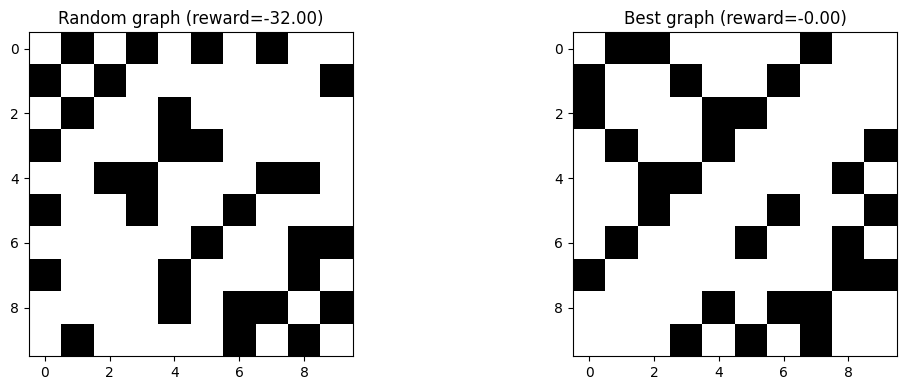

Random reward: -32.00
Construction reward: -0.00
Improvement: 32.00
Parameters: n=10, k=3, lambda=0, mu=1
✅ Model is better than random!


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
num_random_graphs: int = 1000

# Vectorized random edge vectors
random_edge_vecs: torch.Tensor = torch.randint(
    0, 2, (num_random_graphs, problem.edges()), device=device
)
# Vectorized conversion to adjacency matrices
random_adjs_tensor: torch.Tensor = edge_vector_to_adjacency_matrix(random_edge_vecs, n).to(device)
# Vectorized reward computation
with torch.no_grad():
    random_rewards_tensor: torch.Tensor = problem.reward(random_adjs_tensor)

# Keep everything on device until we need to convert for visualization
random_rewards: list[float] = random_rewards_tensor.tolist()
random_adjs: list[torch.Tensor] = list(random_adjs_tensor)

best_random_idx: int = int(torch.tensor(random_rewards).argmax())
random_adj = random_adjs[best_random_idx]
random_reward = random_rewards[best_random_idx]

axes[0].imshow(random_adj.cpu().numpy(), cmap="binary")
axes[0].set_title(f"Random graph (reward={random_reward:.2f})")

axes[1].imshow(best_adj.cpu().numpy(), cmap="binary")
axes[1].set_title(f"Best graph (reward={reward:.2f})")

plt.tight_layout()
plt.show()

print(f"Random reward: {random_reward:.2f}")
print(f"Construction reward: {reward:.2f}")
print(f"Improvement: {reward - random_reward:.2f}")

print(f"Parameters: n={n}, k={k}, lambda={lambda_param}, mu={mu}")

if reward > random_reward:
    print("✅ Model is better than random!")
else:
    print("❌ Model is not better than random - something is wrong")

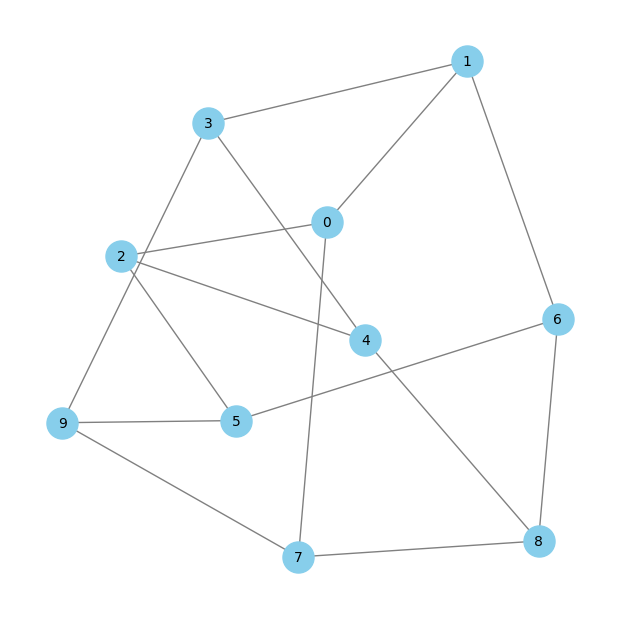

In [35]:
G = nx.from_numpy_array(best_adj.cpu().numpy())

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color="skyblue",
    edge_color="gray",
    node_size=500,
    font_size=10,
)
plt.show()